### Raw local RAG pipeline - An experiment.
<br><br>
+ We're entering the era of LLM-enhanced engineering. New data doesn't mean new training. 
<br><br>
+ Augmented privacy, especially if one is able to run local models with the help of quantization and parameter offloading; Lower cost, although one doesn't get the quality of the currently superior models.

#### Text processing and correspondent embedding.

In [1]:
import os
import requests
import torch

pdf_path = "TCDMAA2413.pdf"

# In case the file doesn't exist yet.
if not os.path.exists(pdf_path):
    print(f"Downloading file")
    url = "https://run.unl.pt/bitstream/10362/145483/1/TCDMAA2413.pdf"
    response = requests.get(url)
    if response.status_code == 200:
        with open(pdf_path, 'wb') as file:
            file.write(response.content)
        print('Downloaded and saved.')
    else:
        print(f'Failed: {response.status_code}')
else:
    print(f"File {pdf_path} exists.")

File TCDMAA2413.pdf exists.


In [8]:
import fitz #pip install PyMuPDF, there are other open PDFs
from tqdm.auto import tqdm
import random

def text_formatter(text:str) -> str:
    """Formatting text. One can do better."""
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str):
    doc = fitz.open(pdf_path)
    pages_and_text = []
    for page_number, page in tqdm(enumerate(doc)):
        text = text_formatter(text = page.get_text())
        pages_and_text.append({"page_number": page_number - 20,
                               "page_char_count": len(text),
                               "page_word_count": len(text.split(" ")),
                               "page_sentence_count_raw": len(text.split(". ")),
                               "page_token_count": len(text)/4, # 1 token ~= 4 chars
                               "text": text })
    return pages_and_text

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
random.sample(pages_and_texts, k=2)

0it [00:00, ?it/s]

[{'page_number': 2,
  'page_char_count': 2030,
  'page_word_count': 306,
  'page_sentence_count_raw': 19,
  'page_token_count': 507.5,
  'text': '1.2. RESEARCH QUESTIONS dynamical framework that responds to the search space needs with different operators might help to further augment their potential for a successful search. When faced with infinity, one might argue that the main problem at hand is the impossibility of knowing the direction towards the solution. When this takes place, one often forgets that there might be additional information that can create a higher probability of positive outcome when rolling the dice. An example of this type of information is simply knowing where not to go. To optimize is essentially to create order. Order often comes from boundaries and these boundaries are abstractions for where not to go. The objective of adapting the geometricity of the search operators is to leverage mathematical hints that point away from a certain direction4. This translates

In [9]:
import pandas as pd
""" As we can see we have an average wordcount of ~217 per page,
    which is acceptable when we take into account that embedding 
    models used further down have a token limit: 384 for each 
    sequence, in this case - all_mpnet-base-v2 model). 
    LLMs, especially smaller ones, also have a request token limit.
    This simply concludes that *most* pages fit our embedding window
    and also inference context window. """

df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,60.00,60.00,60.00,60.00,60.00
mean,9.50,1363.08,216.73,22.70,340.77
std,17.46,1202.99,189.87,56.86,300.75
min,-20.00,0.00,1.00,1.00,0.00
25%,-5.25,150.50,25.75,1.75,37.62
50%,9.50,1610.00,241.50,11.00,402.50
75%,24.25,2484.00,391.50,19.00,621.00
max,39.00,3458.00,533.00,409.00,864.50


##### Further processing (pages to sentences)

In [10]:
from spacy.lang.en import English 

nlp = English()
# Add a sentencizer pipeline, google spacy docs for more info
nlp.add_pipe("sentencizer")
# Create document instance as an example
doc = nlp("Example sentence. Very cool. One could never code this alone. Jokes aside time optimization is king.")
assert len(list(doc.sents))==4

list(doc.sents)

[Example sentence.,
 Very cool.,
 One could never code this alone.,
 Jokes aside time optimization is king.]

In [11]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    # Make sure these are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    # Count sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/60 [00:00<?, ?it/s]

In [16]:
random.sample(pages_and_texts, k=1)

[{'page_number': 21,
  'page_char_count': 2039,
  'page_word_count': 310,
  'page_sentence_count_raw': 15,
  'page_token_count': 509.75,
  'text': 'CHAPTER 3. EXPERIMENT Figure 3.1: DCGA1 portrayed as the blue curve, DCGA2 as the black curve. 3.1.2 P, P’ and SA distinctions The possible adjustments outside of the main framework skeleton1, meaning the pivotal methods that represent the main structure of these versions of genetic algorithms, are innumerable. One should try to capture the questions that are considered important when implementing the methods that account for these non-pivotal details. This is contrary to the ordinary trial and error method implementation that aims for better results across one’s benchmarks, while inadvertently losing generalization ability. Doing so also increases the probability of getting structurally lost without the capacity to causally link certain adjustments on the algorithm to the latest outcomes. Although part of the same framework, P and P’ have 

In [17]:
""" As we can see, the average page count using spacy is not the same as raw,
    but again, raw is simply filtering '. ' and we're going to assume spacy 
    yields accurate and correct results. This can all be refactored as we experiment."""

df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,60.00,60.00,60.00,60.00,60.00,60.00
mean,9.50,1363.08,216.73,22.70,340.77,11.37
std,17.46,1202.99,189.87,56.86,300.75,13.60
min,-20.00,0.00,1.00,1.00,0.00,0.00
25%,-5.25,150.50,25.75,1.75,37.62,2.00
50%,9.50,1610.00,241.50,11.00,402.50,10.00
75%,24.25,2484.00,391.50,19.00,621.00,18.00
max,39.00,3458.00,533.00,409.00,864.50,79.00


##### Chunking sentences together. This should be experimented with. Langchain helps with this, although we're not using it here.<br><br> 
Overall, we should aim at getting chunks that fit our embedding model and LLM context window so we can try to be a bit specific and focused.<br><br>Depending on the GPU/rig available, the embedding models and LLM models we choose will be more powerfull, so this changes a lot and experimentation is the way to go.<br><br> Here I have ~340/11.4= 29 tokens per sentence on average, although the deviation is large, but just to exemplify it would mean that, with sentence chunk size(10) I would get ~290 tokens per chunk, below our 384 limit.


In [18]:
num_sentence_chunk_size = 10

# Function that splits lists of texts into max chunk size, i.e [30] -> [10,10,5]
def split_list(input_list, slice_size = num_sentence_chunk_size):
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

split_list(list(range(25)))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [19]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(item['sentences'])
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/60 [00:00<?, ?it/s]

In [20]:
"""As we can see, in this *specific* page the number of sentences was small,
   we ended up chunking it entirely."""
random.sample(pages_and_texts, k=1)

[{'page_number': 24,
  'page_char_count': 1784,
  'page_word_count': 282,
  'page_sentence_count_raw': 10,
  'page_token_count': 446.0,
  'text': '3.2. BENCHMARK FUNCTIONS landscape. Hence, the assumption that the best solution is most likely found in the last generation(s) of our runs is not correct, or at least not as correct as in all the other algorithms inside our collection: GA, DCGA and SA. Because non-geometric crossover produces episodes of impactful transformation on the underlying space and the standard convex gradient, the best solution might be found in different generations throughout our independent runs. This may possibly create a misleading mean ABF evolution interpretation due to the assimilation of this best solution’s fitness by other fitnesses present on other seeds at that exact generation during that calculation. It is also important to notice that the reason this does not affect P’ is simply its usage of the elitist section of CPSS reduction, that maintains the 

In [21]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,60.00,60.00,60.00,60.00,60.00,60.00,60.00
mean,9.50,1363.08,216.73,22.70,340.77,11.37,1.52
std,17.46,1202.99,189.87,56.86,300.75,13.60,1.38
min,-20.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,-5.25,150.50,25.75,1.75,37.62,2.00,1.00
50%,9.50,1610.00,241.50,11.00,402.50,10.00,1.00
75%,24.25,2484.00,391.50,19.00,621.00,18.00,2.00
max,39.00,3458.00,533.00,409.00,864.50,79.00,8.00


##### Splitting each chunk into its own item/sample --> future numerical representation.

In [22]:
import re 
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"]=item["page_number"]
        
        # Join sentences in order to reach something close to the final form of a sample, like paragraphs.
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # When dot, Capital -> dot, space, Capital
        
        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4 # 1 token = 4 chars
        
        pages_and_chunks.append(chunk_dict)
        
len(pages_and_chunks)
        

  0%|          | 0/60 [00:00<?, ?it/s]

91

In [24]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 12,
  'sentence_chunk': '2.2. SEARCH OPERATORS GEOMETRICITY convex hulls. It conceptually accounts for the possible effect of mutation that may be observed by the expansion of the simple parent connected line (which represents the convex hull of geometric crossover) into a larger stadium geometric shape. In this geometric shape, the radius is equal to K. This evolution is depicted in a pheno- type agnostic environment7 in order to preserve the simplicity and objective of this visualization. Figure 2.7: Convex hull reduction through a generation. Triangles are the offspring created by their parents, the dots. The fact that a certain search strategy is considered a convex search is the reason one is able to explore gradients found in geometrical space, to pursue them, doing what one previously called relevance realization. This is also a fundamental challenge researchers encounter while creating new strategies. The premature convergence prob- lem exists where space explo

In [25]:
""" Ideally, all our chunks would fit the 384 limit but
    as we can see we have about I would guess 10-15% with more than that.
    Maybe after we check the results, if we're not happy,
    we can reduce num_sentence_chunk_size to maybe 8 or so."""

df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,91.00,91.00,91.00,91.00
mean,15.71,896.45,140.96,224.11
std,14.94,635.00,98.63,158.75
min,-20.00,2.00,1.00,0.50
25%,5.50,331.50,46.00,82.88
50%,17.00,777.00,144.00,194.25
75%,29.50,1367.50,226.00,341.88
max,37.00,2524.00,354.00,631.00


##### Filter very small chunks of text as they correlate with less useful infomation.<br><br> Again, this is very subjective and experimental.

In [26]:
# Show random chunk with under X tokens in length to prove it
min_token_length = 45
for row in df[df['chunk_token_count'] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 6.0 | Text: 4Inwardly or outwardly.3
Chunk token count: 44.75 | Text: List of Tables 3.1 Definitions and optimum values of the CEC 2017 benchmark functions. .24 3.2 General testing parameters for all algorithms. . . . . . . . . . . . . . . . .25 xix
Chunk token count: 28.75 | Text: ANNEX I. GENERAL ABF BOXPLOTS Figure I.2: Boxplots of the ABFs over each of the 30 functions with Dimension = 30.38
Chunk token count: 12.25 | Text: “The a priori is greatly neglected.” (Kurt Gödel)
Chunk token count: 17.25 | Text: The difference between these curves can be seen in the Figure 3.1: 21


In [27]:
pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[42:44] # example

[{'page_number': 17,
  'sentence_chunk': 'Evaluate each individual by a fitness function.3. Set the contribution equally for each preference type for the first time.4. Select an individual and its partner with the proposed mating procedure. The probability of choosing a preference type is proportional to its contribution.5. Reproduce two new individuals for the next generation by crossover.6. Repeat step 4 and 5 for the whole population.',
  'chunk_char_count': 399,
  'chunk_word_count': 61,
  'chunk_token_count': 99.75},
 {'page_number': 17,
  'sentence_chunk': '7. Evaluate each new individual by the fitness function.8. Compare the fitness value of the new individuals and their parents. Calculate the contribution of each preference type. Repeat step 4-8 until the final generation is reached.2.4.3 Non-geometric pulse - dynamic geometricity rationale The magnitude of spatial transformation brought by local geometric crossover opera- tions are proportional to the global population’s conv

#### Embedding our text chunks. Text to a-priori trained multidimensional numerical representation.<br><br>
#####   Doing all of the above without a framework was important to understand the underlying processes that are important prior to embedding. Most of these processes are already automated, as referred above.

In [28]:
import torch
torch.cuda.is_available()

True

In [29]:
#!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cuda")

# Create a list of sentences
sentences = ["Greetings, why are you here?",
             "Do you know what you don't know?",
             "Do dogs enjoy fetching or are they helping their owner retrieve the object for the tenth time?"]

embeddings = embedding_model.encode(sentences)
embedding_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embedding_dict.items():
    print(f'Sentence: {sentence}')
    print(f'Embedding: {embedding}')
    print("")

Sentence: Greetings, why are you here?
Embedding: [ 3.96967158e-02 -3.09437085e-02  1.03976168e-02 -1.91420708e-02
  3.52884866e-02 -6.92638196e-03  9.88276443e-04 -1.71525013e-02
  4.27119024e-02  1.90434139e-02  8.21249746e-03 -1.98120102e-02
  1.78379118e-02 -2.92429086e-02  4.97386232e-02 -5.09328619e-02
  1.67524088e-02 -6.06374396e-03  4.63726558e-02  2.63362261e-03
  2.50573270e-02  1.27781508e-02  1.61363427e-02  1.30940219e-02
 -1.32507486e-02  9.07435548e-03  5.07931970e-02  8.04467723e-02
  4.95054154e-03  5.24804108e-02 -3.74819292e-03 -5.01613766e-02
  2.27598939e-02 -2.16224752e-02  1.88179820e-06  3.29595096e-02
  1.62600763e-02  2.12407280e-02 -5.60974069e-02 -7.98543096e-02
 -1.41071584e-02  8.13930109e-03 -4.27870499e-03  4.99794744e-02
  1.19429547e-02 -4.35163975e-02  2.34481674e-02  1.37561560e-02
 -2.68216524e-03  7.42032230e-02 -1.31682577e-02 -1.11158444e-02
 -6.26365617e-02 -2.67679282e-02 -1.34492237e-02  1.46074351e-02
 -1.31631922e-02 -1.30969298e-03  4.9966

In [30]:
embeddings[0].shape

(768,)

In [31]:
%%time
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/79 [00:00<?, ?it/s]

CPU times: total: 8.34 s
Wall time: 1.06 s


In [32]:
%%time
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=128, convert_to_tensor=True)
text_chunk_embeddings
# much better as a test

CPU times: total: 2.38 s
Wall time: 864 ms


tensor([[-0.0482,  0.0641, -0.0850,  ...,  0.0137, -0.0026, -0.0290],
        [-0.0594,  0.0215, -0.0773,  ...,  0.0021, -0.0270,  0.0040],
        [-0.0538, -0.0356, -0.0529,  ...,  0.0007,  0.0051,  0.0052],
        ...,
        [-0.0057, -0.0535, -0.0298,  ...,  0.0297,  0.0534, -0.0408],
        [-0.0324, -0.0292, -0.0080,  ..., -0.0008,  0.0137,  0.0116],
        [-0.0207,  0.0375, -0.0659,  ...,  0.0191,  0.0128, -0.0464]],
       device='cuda:0')

##### Save embedding to file

In [33]:
pages_and_chunks_over_min_token_len[40]

{'page_number': 16,
 'sentence_chunk': 'This work will consider a successful crossover one that produces at least one offspring with a superior or equal fitness than both parents if not equal in representation to any of both, instead of superior only as was portrayed in [17]. This detailed difference arrives from the assumption that in the rare event of an offspring possessing the same fitness as its best parent, besides the possibility of that offspring and a parent coinciding, the creation of a solution in a new spatial position that is not inferior in fitness is a positive 11Meaning with any type of selection method, contrary to x2.12Only the first selected parents are assigned one preference type that will be used to find their mates.17',
 'chunk_char_count': 710,
 'chunk_word_count': 120,
 'chunk_token_count': 177.5,
 'embedding': array([-4.04180959e-02, -5.75676411e-02, -1.59001816e-02, -2.10645776e-02,
        -4.61496748e-02, -4.01603617e-02, -2.11011060e-02, -1.20713413e-02,
 

In [34]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [37]:
# Import saved file and view... btw no need to use vector database, files will be small in my usecase
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load[40:45]

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
40,16,This work will consider a successful crossover...,710,120,177.50,[-4.04180959e-02 -5.75676411e-02 -1.59001816e-...
41,17,CHAPTER 2. METHODS event. One can intuitively ...,1133,172,283.25,[-2.18403526e-03 -4.61876057e-02 -3.27629521e-...
42,17,Evaluate each individual by a fitness function...,399,61,99.75,[ 1.00221357e-03 -1.89846230e-03 -2.04933584e-...
43,17,7. Evaluate each new individual by the fitness...,1143,167,285.75,[-4.56535742e-02 -2.16591787e-02 -3.45022157e-...
44,18,2.4. ADAPTIVE FRAMEWORK AND NON-GEOMETRIC OPER...,1664,242,416.00,[-1.77406613e-02 -4.04539332e-02 -3.84038165e-...


#### Retrieval - semantic search <br><br>
Based on a query, get relevant document passages. After, we join these passages with our LLM input questions.<br><br>
That's basically it, the crux of all this notebook.

In [38]:
import numpy as np
import torch
import warnings
warnings.filterwarnings('ignore')

# Doing this because later I might want to start from here.
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")
# Convert embedding column to np.array instead of string
text_chunks_and_embeddings_df["embedding"]=text_chunks_and_embeddings_df["embedding"].apply(lambda x:np.fromstring(x.strip("[]"), sep=" "))

embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to("cuda")
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient = "records")
text_chunks_and_embeddings_df[21:27]

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
21,6,"d(p,q) = ♯{i : pi , qi,i = 1,...,n} • Euclidia...",557,95,139.25,"[-0.0233100802, 0.0448890813, -0.0259991996, -..."
22,7,CHAPTER 2. METHODS (a) Hamming distance throug...,1231,189,307.75,"[-0.0185549185, 0.0145103959, -0.0626288354, -..."
23,7,For a recombination technique to be considered...,515,92,128.75,"[-0.0226568412, -0.0652327687, -0.00520132156,..."
24,8,2.2. SEARCH OPERATORS GEOMETRICITY The fundame...,1365,217,341.25,"[-0.0390628278, -0.0651190206, -0.034659218, 0..."
25,8,Both rep- resent a lower end of complexity reg...,1137,173,284.25,"[-0.0547372773, -0.0570284575, -0.0405546241, ..."
26,9,CHAPTER 2. METHODS (a) One-point crossover sin...,1319,202,329.75,"[-0.0456023328, -0.0555918477, -0.0258388259, ..."


In [39]:
embeddings.shape

torch.Size([79, 768])

In [40]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cuda")

In [41]:
query = "geometric crossover"
print(f"Query: {query}")
# Obviously, we need to embed our queries with the same model we embedded our text chunks.
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# Similarity scores (important to 1-have them both on same device and 2-have them with the same float)
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
top_results = torch.topk(dot_scores, k=5)
top_results

# Also important to refer that this is extremely fast but if we have billions of chunks,
# we should find more efficient ways to perform this, instead of exhaustive dot_score comparing.

Query: geometric crossover


torch.return_types.topk(
values=tensor([0.6405, 0.5931, 0.5692, 0.5332, 0.5324], device='cuda:0'),
indices=tensor([25, 23, 24, 46, 71], device='cuda:0'))

In [42]:
# Check top page/indices
pages_and_chunks[25]

{'page_number': 8,
 'sentence_chunk': 'Both rep- resent a lower end of complexity regarding the vast amount of crossovers that can be used to further introduce dynamic geometricity. These provide a level of simplicity that is useful when creating the idea of such a framework. This choice also mitigates the causal relationship between the usage of more specific complex types of crossover and general results of one’s algorithm, maintaining the focus on the essence of the strategy employed in this work. One-point crossover [10] is a mask-based crossover for binary strings. It uniformly produces offspring in the segment between the two parents, respecting all our previous properties, thus being referred as a uniform geometric crossover as represented in Fig- ure 2.3(a). This crossover works by choosing a random number in range of the parent’s representation length, then cutting and swapping tails (Figure 2.4(a)). Extension ray crossover [11] extends the segment passing through both parents

##### Make our vector search more presentable

In [43]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(top_results[0], top_results[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}\n")
    

Query: 'geometric crossover'

Results:
Score: 0.6405
Text:
Both rep- resent a lower end of complexity regarding the vast amount of
crossovers that can be used to further introduce dynamic geometricity. These
provide a level of simplicity that is useful when creating the idea of such a
framework. This choice also mitigates the causal relationship between the usage
of more specific complex types of crossover and general results of one’s
algorithm, maintaining the focus on the essence of the strategy employed in this
work. One-point crossover [10] is a mask-based crossover for binary strings. It
uniformly produces offspring in the segment between the two parents, respecting
all our previous properties, thus being referred as a uniform geometric
crossover as represented in Fig- ure 2.3(a). This crossover works by choosing a
random number in range of the parent’s representation length, then cutting and
swapping tails (Figure 2.4(a)). Extension ray crossover [11] extends the segment
passing 

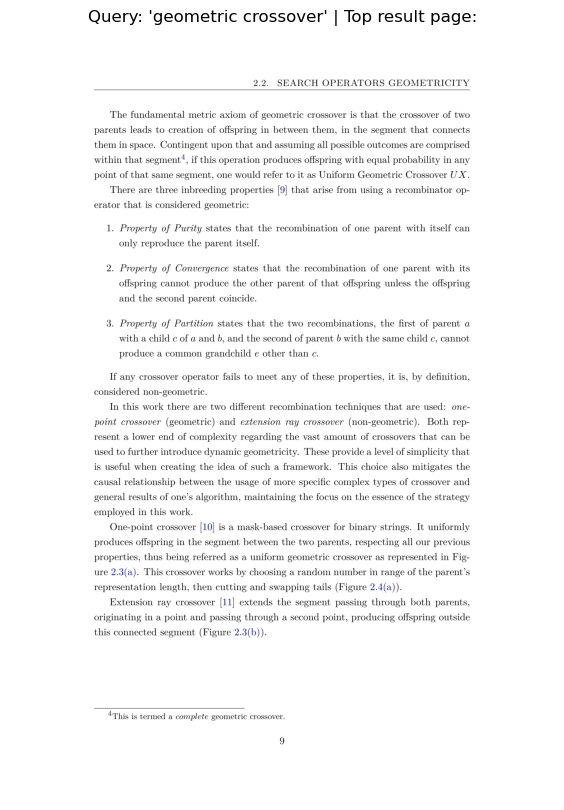

In [44]:
import fitz
import matplotlib.pyplot as plt

pdf_path = "TCDMAA2413.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(8+20) # +20 because of the early change to disregard pages before the main text

img = page.get_pixmap(dpi=500)
doc.close()
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Top result page:")
plt.axis("off")
plt.show()

##### Different similarities - dot product (previously used) and cosine (usally better for text similarity, assuming the embeddings aren't already normalized) - quick analysis

In [45]:
def dot_product(v1,v2):
    return torch.dot(v1, v2)

def cosine_similarity(v1, v2):
    dot = dot_product(v1, v2)
    norm_v1 = torch.sqrt(torch.sum(v1**2))
    norm_v2 = torch.sqrt(torch.sum(v2**2))
    return dot/(norm_v1*norm_v2)

v1 = torch.tensor([1,2,3], dtype=torch.float32)
v2 = torch.tensor([1,2,3], dtype=torch.float32)
v3 = torch.tensor([4,5,6], dtype=torch.float32)
v4 = torch.tensor([-1,-2,-3], dtype=torch.float32)

print("Dot product v1v2:", dot_product(v1,v2))
print("Dot product v1v3:", dot_product(v1,v3))
print("Dot product v1v4:", dot_product(v1,v4))
print("Cos sim v1v2:", cosine_similarity(v1,v2))
print("Cos sim product v1v3:", cosine_similarity(v1,v3))
print("Cos sim product v1v4:", cosine_similarity(v1,v4))

Dot product v1v2: tensor(14.)
Dot product v1v3: tensor(32.)
Dot product v1v4: tensor(-14.)
Cos sim v1v2: tensor(1.0000)
Cos sim product v1v3: tensor(0.9746)
Cos sim product v1v4: tensor(-1.0000)


##### Functionizing our semantic search pipeline

In [46]:
def retrieve_relevant_resources(query, embeddings, model=embedding_model, n_resources_to_return=5):
    query_embedding = model.encode(query, convert_to_tensor=True)
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)
    return scores, indices


def print_top_results_and_scores(query, embeddings,
                                 pages_and_chunks=pages_and_chunks, n_resources_to_return=5):
    scores, indices = retrieve_relevant_resources(query, embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}\n")


In [47]:
query = "material contraction"
retrieve_relevant_resources(query, embeddings)
print_top_results_and_scores(query, embeddings)

Score: 0.2488
Text:
CHAPTER 2. METHODS offspring created by this method in Figure 2.8. On the other
hand, material contraction will only occur when geometric crossover superimposes
non-geometric crossover, with respect to the number of occurrences and their
spatial outcomes in a generation. If this is the case, in the event that non-
geometric crossover does not produce any solution outside of the global convex
hull, we can equate this material contraction with a search space reduction.
Ideally, the moment convex search starts having mostly negative effects on our
phe- notypes, the contributions of the preferences that employ geometric
crossover decrease. Non-convex search will have an increased share of
occurrences as the contribution of the preference that employs non-geometric
crossover takes a larger slice of our pool of contributions. Likewise, there
will also be moments where non-convex search will have a negligible share in our
generational process, creating an interesting diver

### Local LLM time

In [48]:
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes/(2**30))
print(f'Available GPU memory: {gpu_memory_gb} GB')
# this means if I use a 7B parameter model like mistral or gemma, I have to go for the 8/4-bit implementation.
# also need to check huggingface CLI stuff, etc...

Available GPU memory: 10 GB


In [49]:
# Gemma focused
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 10 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [50]:
# !pip install transformers in case one doesn't have it already
# !pip install ninja
# !pip install flash-attn --no-build-isolation this might not work depending on GPU, OS, other dependencies
# !pip install bitsandbytes accelerate, for quantization

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available # good for local attention speedups, >=3000 series
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bits=True, bnb_4bit_compute_dtype = torch.float16)

# bonus if one is able to get flash attn 2, run torch.cuda.get_device_capability(0)[0] to check if >=8.0
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >=8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" #scaled dot prod attn
    
# This will be our tokenizer for our future LLM prompts
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False,
                                                 attn_implementation=attn_implementation)
if not use_quantization_config:
    llm_model.to('cuda')

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [58]:
def get_model_num_params(model):
    return sum([param.numel() for param in model.parameters()])
get_model_num_params(llm_model)

2506172416

In [63]:
def get_model_mem_size(model):
    mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
    
    model_mem_bytes = mem_params+mem_buffers
    model_mem_gb = model_mem_bytes/(1024**3)
    return {"model_mem_gb": model_mem_gb}
get_model_mem_size(llm_model)

{'model_mem_gb': 4.668109893798828}

#### Generate with Gemma<br><br>
Because Gemma(_it) is an instructed tuned model, one should take into account their chat templates.

In [67]:
input_text = "What makes a crossover operator be labeled as geometric crossover?"
print(f"Input text:\n{input_text}")

dialogue_template = [{"role": "user", "content": input_text}]
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What makes a crossover operator be labeled as geometric crossover?

Prompt (formatted):
<bos><start_of_turn>user
What makes a crossover operator be labeled as geometric crossover?<end_of_turn>
<start_of_turn>model



In [70]:
%%time
# Tokenize prompt
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
input_ids

# Generate outputs from local LLM
outputs = llm_model.generate(**input_ids, max_new_tokens=256)
print(f"Output:\n {outputs[0]}\n")

Output:
 tensor([     2,      2,    106,   1645,    108,   1841,   3833,    476,  58115,
         11694,    614,  36694,    685,  30323,  58115, 235336,    107,    108,
           106,   2516,    108, 235280,  30323,  58115,  11694,    603,    476,
          1916,    576,  22033,  11694,    674,    603,   1671,    575,  58313,
         28514,    577,   4771,    573,  19871,    576,   8319,    577,    476,
          3210, 235265,   1165,    603,    476,  16679,    576,    573,   5039,
         58115,  11694, 235269,    948,    603,   1671,    577,   3104,  55204,
           731, 109330,  22033,   2113,   1865,   1378,   3910,  70753, 235265,
           109,    886,  30323,  58115, 235269,    573,  55204,    708,   5483,
           731,   4998,    476,   1142,    576,   3782,    611,    573,   1378,
          3910,  70753,    578,  24497,   1174,    575,    476,  30323,   6883,
        235269,   1582,    685,    476,   2017, 235269,    476,  11698, 235269,
           689,    476,  39283,

In [72]:
# Decoding
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Output decoded:\n {outputs_decoded}\n")

# This is actually a horrible answer from the baseline model. Makes sense, the topic is slightly niche.

Output decoded:
 <bos><bos><start_of_turn>user
What makes a crossover operator be labeled as geometric crossover?<end_of_turn>
<start_of_turn>model
A geometric crossover operator is a type of genetic operator that is used in evolutionary algorithms to improve the diversity of solutions to a problem. It is a variation of the standard crossover operator, which is used to create offspring by swapping genetic information between two parent chromosomes.

In geometric crossover, the offspring are created by taking a set of points on the two parent chromosomes and connecting them in a geometric pattern, such as a line, a circle, or a spiral. The points are then used to create the offspring chromosome.

The geometric crossover operator has a number of advantages over the standard crossover operator. First, it can help to create offspring that are more diverse than offspring created by the standard crossover operator. Second, it can help to improve the quality of the offspring chromosome by red

#### Augmenting our prompt with context items, finally!

In [128]:
def prompt_formatter(query, context_items):
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    
    base_prompt = """Based on the following context items, answer the query.
Query: {query} 
Context items:
{context}
Answer:
""" # This is where the art of prompt engineering occurs. Different trials. Exemplify Q&As, etc...
    prompt = base_prompt.format(context=context, query=query)
    
    # Create prompt template for instruction-tuned model
    dialogue_template=[{"role":"user",
                       "content":prompt}]
    
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)
    
    return prompt

query=input_text #"What makes a crossover operator be labeled as geometric crossover?"

# Get relevant chunks with the help of our previous work.
scores, indices = retrieve_relevant_resources(query, embeddings)

# List of chunk context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query, context_items)
print(prompt)

# Very acceptable retrieved results! By the way remember that maybe not all this below fits the context window.
# Can't wait for our model to answer our query with this Retrieved Augmented added context, let's Generate.

<bos><start_of_turn>user
Based on the following context items, answer the query.
Query: What makes a crossover operator be labeled as geometric crossover? 
Context items:
- For a recombination technique to be considered geometric or not, it must abide by the following definitions [8]: • geometric crossover class G: a recombination OP belongs to this class if there exists at least a distance d under which such a recombination is geometric: OP ∈G⇐ ⇒∃d : ∀p1,p2 ∈S : Im[OP (p1,p2)] ⊆[p1,p2]d • non-geometric crossover class G : a recombination OP belongs to G if there is no distance d under which such a recombination is geometric: OP ∈G⇐ ⇒∀d : ∃p1,p2 ∈S : Im[OP (p1,p2)]\[p1,p2]d , ∅ 8
- 2.2. SEARCH OPERATORS GEOMETRICITY The fundamental metric axiom of geometric crossover is that the crossover of two parents leads to creation of offspring in between them, in the segment that connects them in space. Contingent upon that and assuming all possible outcomes are comprised within that segment4, i

In [130]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# temperature adjusts our exponencial softmax power - token probability function
outputs = llm_model.generate(**input_ids,
                             temperature=0.7,
                             do_sample=True,
                             max_new_tokens=256) 

output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt, '')}")
# Generation completed, full RAG process lead to a superior explanation than the baseline model.

Query: What makes a crossover operator be labeled as geometric crossover?
RAG answer:\m<bos>The query explains that geometric crossover is a recombination operator that leads to the creation of offspring in between the two parents, in the segment that connects them in space.<eos>
CPU times: total: 24 s
Wall time: 24 s


In [114]:
%%time
# different base prompt trials that are not showed above
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# temperature adjusts our exponencial softmax power - token probability function
outputs = llm_model.generate(**input_ids,
                             temperature=0.7,
                             do_sample=True,
                             max_new_tokens=256) 

output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt, '')}")
# Generation completed, full RAG process lead to a superior explanation than the baseline model.

Query: What makes a crossover operator be labeled as geometric crossover?
RAG answer:\m<bos>

**Summary:**

- Geometric crossover is a type of crossover that leads to offspring that are located in the same segment as the parents.
- Non-geometric crossover is a type of crossover that leads to offspring that are located outside the segment of the parents.
- The geometric crossover operator can be represented by a mask that cuts and swaps tails of the parents to produce offspring.
- The extension ray crossover operator extends the segment passing through both parents, originating in a point and passing through a second point, producing offspring outside this connected segment.
- The adaptive framework and non-geometric operator placement can be used to achieve different levels of geometricity in the search space, with the geometric crossover operator being used when the preference type is high, while the non-geometric crossover operator is used when the preference type is low.<eos>
CPU ti

### Functionize LLM answering feature - Final

In [131]:
def ask(query, temperature=0.7, max_new_tokens=256, format_answer_text=True, return_answer_only=True):
    """Takes query, finds context in our document, generates an answer based on that context. RAG."""
    # RETRIEVAL - Get scores, indices
    scores, indices = retrieve_relevant_resources(query, embeddings)
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]
    # Add score to context item
    for i,item in enumerate(context_items):
        item["score"] = scores[i].cpu()
    
    # AUGMENTATION - Create prompt and format it with context
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # GENERATION
    input_ids = tokenizer(prompt, return_tensors="pt").to('cuda')
    outputs = llm_model.generate(**input_ids,
                                 temperature = 0.7,
                                 do_sample = True,
                                 max_new_tokens = max_new_tokens)
    output_text = tokenizer.decode(outputs[0])
    
    # Format the answer
    if format_answer_text:
        output_text = output_text.replace(prompt, '').replace('<bos>','').replace('eos', '')
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [135]:
query = "How does P and P' compare to other algorithms in the experiment section?"
print(f"Query: {query}")
ask(query)

Query: How does P and P' compare to other algorithms in the experiment section?


"P and P' are two algorithms that compete with other algorithms in the experiment section. P' uses a global population difference function tournament to find its most preferred candidate in the entire population, while P uses a random selected limited set of candidates. The second level of analysis revealed that P or P' concerning the ABF for 25/30 functions using the 10- dimensional test and 27/30 using the 30-dimensional test.<>"

In [139]:
# Another test
query = "What crossover type do P and P' use that other algorithms do not?"
print(f"Query: {query}")
ask(query, temperature=0.5, return_answer_only=False) # check relevant passages

Query: What crossover type do P and P' use that other algorithms do not?


("P and P' use the concept of non-convex search, which introduces a preference level for non-geometric crossover compared to the one-point crossover used by other algorithms. This concept leads to the maximization of the possible distance in the extended line that originates in one parent x1 and crosses another x2, instead of uniformly creating offspring in the segment from x2 until the maximum travelled distance.<>",
 [{'page_number': 8,
   'sentence_chunk': '2.2. SEARCH OPERATORS GEOMETRICITY The fundamental metric axiom of geometric crossover is that the crossover of two parents leads to creation of offspring in between them, in the segment that connects them in space. Contingent upon that and assuming all possible outcomes are comprised within that segment4, if this operation produces offspring with equal probability in any point of that same segment, one would refer to it as Uniform Geometric Crossover UX. There are three inbreeding properties [9] that arise from using a recombina

# Done :)